# Исследование данных по продаже игр

Цель проекта:
 - изучить данные по продажам игр за прошлые периоды
 - определить факторы влияющие на успех игр
 - определить, на продажу каких игр стоит направить деятельность интернет-магазина

## Подготовка данных

Подключим необходимые для исследования библиотеки, загрузим данные и посмотрим на них.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections
from statsmodels.graphics.gofplots import qqplot
from scipy import stats as st

In [2]:
df = pd.read_csv('/datasets/games.csv')
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [3]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

Сразу поправим названия столбцов, чтобы не наделать ошибок потом. Также я убедился, что в них нет лишних пробелов.

In [4]:
df.columns = df.columns.str.lower()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null object
year_of_release    16446 non-null float64
genre              16713 non-null object
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         10014 non-null object
rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Всего у нас 16715 записей, из них:
 - две без названия, при этом другие поля частично заполнены, вероятно их можно будет назвать как угодно и оставить в исследовании
 - пропуски по году выхода
 - две записи без указания жанра
 - и больше всего пропусков в оценках игр

In [6]:
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Данные собраны за период с 1980 года по 2016 (мы знаем, что не полный 2016). Как минимум 25% записей имеют нули по продажам - нужно будет убедиться, что так и есть, в любом случае заполнить самостоятельно мы их не сможем.

### Типы данных и пропуски

Заменим типы данных:
 - platform и genre - категорийные значения, убедимся только, что у нас нет нескольких значений в одной ячейке
 - год выпуска - только положительное целое число, поэтому используем uint64
 - рейтинг - ранговое значение, но я оставлю его как unit64, предварительно убедившись, что все значения целые
 - рейтинг - категория

In [7]:
df['platform'].value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
GB        98
NES       98
DC        52
GEN       29
NG        12
WS         6
SCD        6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

In [8]:
df['genre'].value_counts()

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

Все платформы и жанры представлены одним обозначением (нет вариантов 'Xbox, PS4, PC'), приведём к соответствующему типу.

In [9]:
df['platform'] = df['platform'].astype('category')
df['genre'] = df['genre'].astype('category')
df['year_of_release'].fillna(value=0, inplace=True)
df['year_of_release'] = df['year_of_release'].astype('uint64')

Пропуски по годам я заменил 0, их всего около 300 и я смогу выделить их отдельно и не использовать при необходимости

Разберёмся с оценками

In [10]:
df['user_score'].value_counts()

tbd    2424
7.8     324
8       290
8.2     282
8.3     254
       ... 
1.1       2
1.5       2
1.9       2
0         1
9.7       1
Name: user_score, Length: 96, dtype: int64

In [11]:
df['critic_score'].value_counts()

70.0    256
71.0    254
75.0    245
78.0    240
73.0    238
       ... 
20.0      3
17.0      1
22.0      1
13.0      1
21.0      1
Name: critic_score, Length: 82, dtype: int64

Оценки игроков отмечены дробными числами, вероятно потому, что они считаются как средняя оценка. Оценки критиков обычно являются суммой оценок нескольких критиков, поэтому они все целочисленные. Посмотрим на отсутствующие значения.

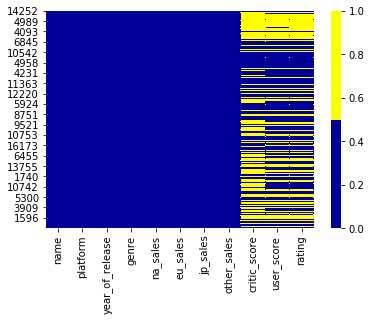

In [12]:
colours = ['#000099', '#ffff00'] 
sns.heatmap(df.sort_values(by='year_of_release').isnull(), cmap=sns.color_palette(colours))

Для большого количества значений рейтинг не определён. Предположу, что это может быть для игр вышедших давно, когда не было такой оценки (или возможности собрать столько оценок), но на графике видно, что такая проблема сохраняется. 
Можно предположить, что какие-то игры не получают оценок вообще (можно посмотреть на их продажи, если возникнет такой вопрос) либо есть проблема с хранением и сбором информации.
В любом случае эти данные нам сейчас не доступны.

Отсутствующие значения и tbd я заменю 9999 и не буду их использовать в дальнейшем при изучении этих показателей.

In [20]:
df['user_score']=pd.to_numeric(df['user_score'], errors='coerce')
df['critic_score']=pd.to_numeric(df['critic_score'], errors='coerce')
df['user_score'] = df['user_score'].where(df['user_score'] != 'tbd', 9999)
df['user_score'].value_counts()

7.8    324
8.0    290
8.2    282
8.3    254
8.5    253
      ... 
9.6      2
0.6      2
1.9      2
9.7      1
0.0      1
Name: user_score, Length: 95, dtype: int64

Теперь мы можем проводить нужные операции со значениями оценок. Оценки критиков оставим целочисленными, а игроков - float

Осталось разобраться с рейтингами. Посчитать о них можно <a href='https://www.esrb.org/ratings-guide/'>здесь</a>.

In [21]:
df['rating'].value_counts()

E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: rating, dtype: int64

In [22]:
df.replace({'rating':{'K-A': 'E', 'AO':'M'}}, inplace=True)

In [23]:
df['rating'].isnull().sum()

6766

In [24]:
df.query('rating ==  "RP"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
13672,Clockwork Empires,PC,0,Strategy,0.0,0.04,0.0,0.00,58.0,3.8,RP
14270,Supreme Ruler: Cold War,PC,2011,Strategy,0.0,0.03,0.0,0.01,63.0,6.8,RP
16180,WRC: FIA World Rally Championship,PC,0,Racing,0.0,0.01,0.0,0.00,65.0,NaN,RP


В датасете для 6766 игр отсутствует рейтинг ESRB и только у трёх есть значение PR (которое значит, что игра ещё не оценена). Из 3-х игр, две вышли намного ранее 2016 года, поэтому я не считаю, что оценки нет из-за недавнего релиза игры. Поэтому пропущенные значения я заменю на RP и не будут их использовать при оценке данных.

In [25]:
df['rating'].fillna(value='RP', inplace=True)
df['rating'] = df['rating'].astype('category')

Привели всё к нужным типам и частично разобрались с пропусками, посмотрим на результат.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16715 non-null category
year_of_release    16715 non-null uint64
genre              16713 non-null category
na_sales           16715 non-null float64
eu_sales           16715 non-null float64
jp_sales           16715 non-null float64
other_sales        16715 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             16715 non-null category
dtypes: category(3), float64(6), object(1), uint64(1)
memory usage: 1.1+ MB


А что с отсутствующими названиями?

In [27]:
df.sort_values(by='name').tail(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,RP
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,RP


По двум играм у нас нет названия, жанра, оценок от критиков, но есть какие-то продажи. Возможно Платформа и год смогут нам помочь.

In [28]:
df.query('platform == "GEN"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
145,Sonic the Hedgehog 2,GEN,1992,Platform,4.47,1.20,0.16,0.19,NaN,NaN,RP
257,Sonic the Hedgehog,GEN,1991,Platform,3.03,0.91,0.26,0.13,NaN,NaN,RP
564,Mortal Kombat,GEN,1992,Fighting,1.95,0.63,0.00,0.09,NaN,NaN,RP
588,Streets of Rage,GEN,1990,Action,1.86,0.55,0.11,0.08,NaN,NaN,RP
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,RP
832,NBA Jam,GEN,1992,Sports,1.75,0.25,0.00,0.05,NaN,NaN,RP
960,Sonic & Knuckles,GEN,1994,Platform,1.24,0.43,0.03,0.12,NaN,NaN,RP
996,Sonic the Hedgehog 3,GEN,1994,Platform,1.02,0.47,0.20,0.07,NaN,NaN,RP
1099,Street Fighter II': Special Champion Edition,GEN,1992,Fighting,1.00,0.30,0.31,0.04,NaN,NaN,RP
1365,Disney's The Lion King,GEN,1994,Platform,0.97,0.37,0.03,0.05,NaN,NaN,RP


<a href='https://en.wikipedia.org/wiki/List_of_best-selling_Sega_Genesis_games'>Википедия</a> не пришла на помощь, поэтому эти строки мы просто удалим и не будем использовать.

In [29]:
df.dropna(subset=['name'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name               16713 non-null object
platform           16713 non-null category
year_of_release    16713 non-null uint64
genre              16713 non-null category
na_sales           16713 non-null float64
eu_sales           16713 non-null float64
jp_sales           16713 non-null float64
other_sales        16713 non-null float64
critic_score       8137 non-null float64
user_score         7590 non-null float64
rating             16713 non-null category
dtypes: category(3), float64(6), object(1), uint64(1)
memory usage: 1.2+ MB


In [30]:
df.head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,RP
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,RP
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,RP
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,RP


Похоже, что с данными теперь всё в порядке.

In [31]:
df['name'].duplicated().sum()

5154

In [32]:
df[df["name"].isin(df["name"][df["name"].duplicated()])].sort_values("name")

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
3862,Frozen: Olaf's Quest,DS,2013,Platform,0.21,0.26,0.00,0.04,NaN,NaN,RP
3358,Frozen: Olaf's Quest,3DS,2013,Platform,0.27,0.27,0.00,0.05,NaN,NaN,RP
14658,007: Quantum of Solace,PC,2008,Action,0.01,0.01,0.00,0.00,70.0,6.3,T
9507,007: Quantum of Solace,DS,2008,Action,0.11,0.01,0.00,0.01,65.0,NaN,T
3120,007: Quantum of Solace,Wii,2008,Action,0.29,0.28,0.01,0.07,54.0,7.5,T
...,...,...,...,...,...,...,...,...,...,...,...
2583,pro evolution soccer 2011,PSP,2010,Sports,0.05,0.30,0.29,0.16,74.0,5.8,E
7149,pro evolution soccer 2011,Wii,2010,Sports,0.07,0.10,0.03,0.02,78.0,5.4,E
12648,pro evolution soccer 2011,PC,2010,Sports,0.00,0.05,0.00,0.01,79.0,NaN,RP
15612,uDraw Studio: Instant Artist,X360,2011,Misc,0.01,0.01,0.00,0.00,54.0,5.7,E


Также я проверил, что данные по играм собраны отдельно по каждой платформе и имеют на них различные оценки и показатели продаж.

In [33]:
len(df['name'].unique())

11559

Всего у нас 11559 уникальных релизов.

### Подготовка данных

Добавляю столбец с информацией о суммарных продажах во всех регионах.

In [34]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,RP,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,RP,31.38


## Исследовательский анализ данных

### Годы выпуска игр

Посмотрим, сколько игр выпускалось в разные годы.

In [35]:
years = sorted(df.query('year_of_release > 0')['year_of_release'].unique())

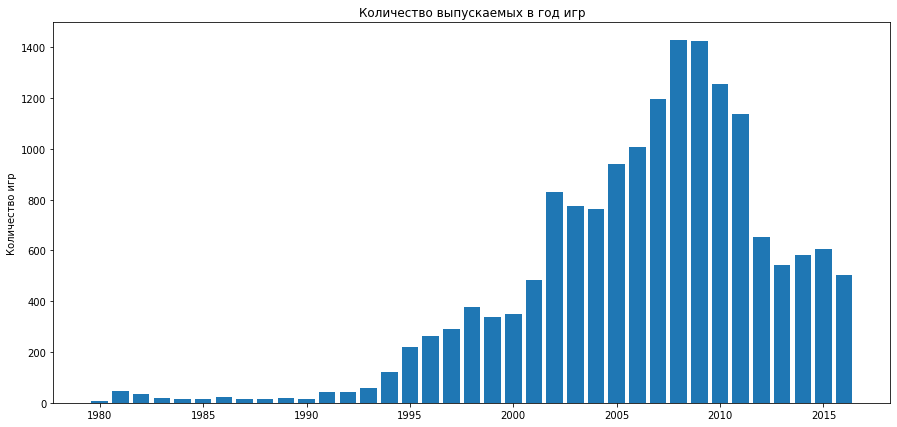

In [36]:
plt.figure(figsize=(15,7))
plt.bar(years , df.query('year_of_release > 0').groupby('year_of_release')['year_of_release'].count())
plt.title('Количество выпускаемых в год игр')
plt.ylabel('Количество игр')
plt.show()

На графике мы видим небольшое плато с 1980 по 1993 годы, когда выпуск игр был достаточно регулярным, но не показывал значительного роста. Начиная с 1993 по 2008 мы наблюдаем стремительный рост связанный с быстром ростом технологий и появлением большого количества новых игровых платформ. С 2008 по 2012 был спад и далее количество выпускаемых игр осталось на том же уровне.

Для анализа мы можем использовать данные за период 2000 - 2015 год, вероятно они лучше будут отражать предпочтения пользователей, т.к. взяты за актуальный период, а также лучше будут показывать данные по продажам, т.к. игровые устройства стали доступнее и более массовыми, также я смогу не упустить значимые релизы и серии, которые имеют большую историю. В любом случае показатели продаж нельзя рассматривать отдельно от года выхода игр и платформы, на которой они выходят.

### Продажи игр

Продажи игр есть смысл оценивать в трёх разрезах, год выхода, платформа и жанр. Начнём с платформы, заодно выделим наиболее популярные.

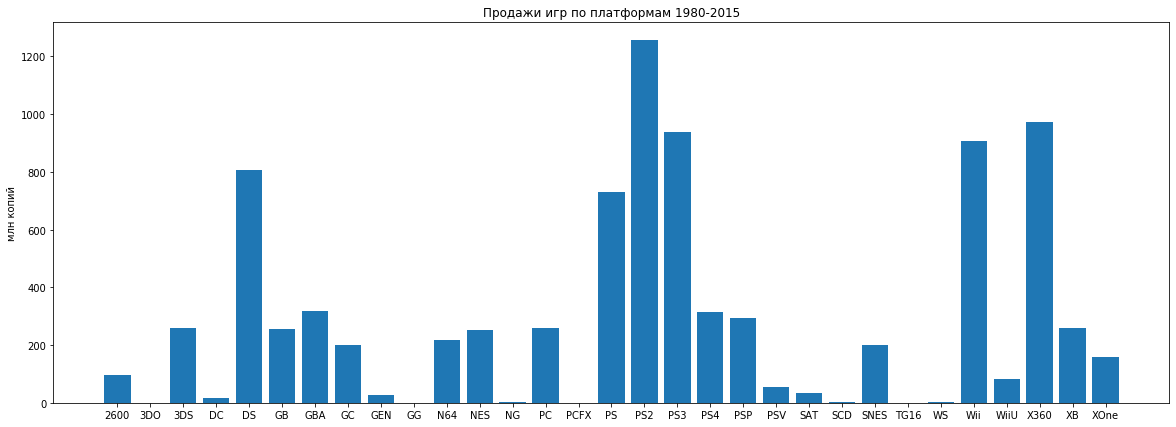

In [37]:
plt.figure(figsize=(20,7))
plt.bar(sorted(df['platform'].unique()), 
        df.groupby('platform')['total_sales'].sum())
plt.title('Продажи игр по платформам 1980-2015')
plt.ylabel('млн копий')
plt.show()

На графике явно видны 6 фаворитов. Также видна вторая группа с близкими показателями между собой, среди которых можно увидеть PS4 и Xbox One вышедшие недавно. Посмотрим на данные за более актуальный период.

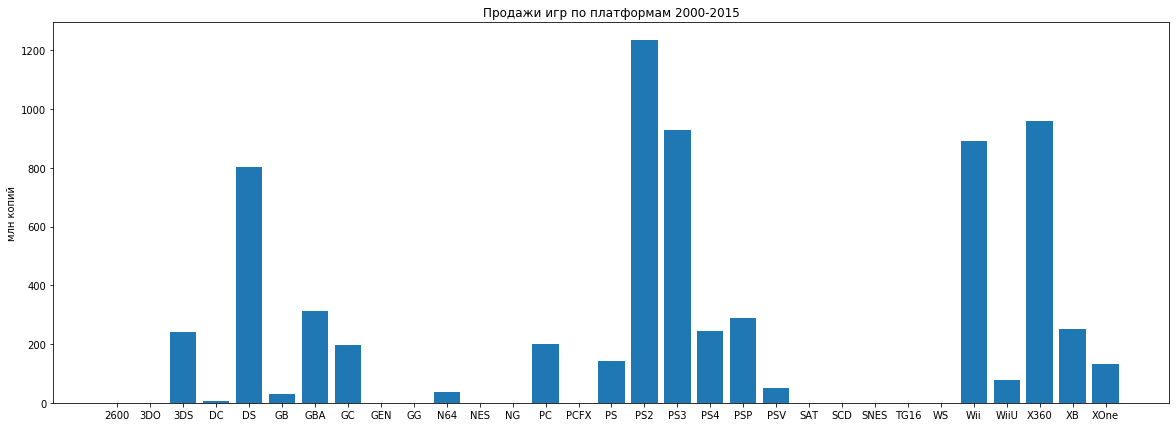

In [38]:
plt.figure(figsize=(20,7))
plt.bar(sorted(df['platform'].unique()), 
        df.query('2015 >= year_of_release >= 2000').groupby('platform')['total_sales'].sum())
plt.title('Продажи игр по платформам 2000-2015')
plt.ylabel('млн копий')
plt.show()

За последние 15 полных лет больше всего денег заработали 5 платформ: DS, PS3, PS3, Wii и Xbox360. Кроме того на графиках наглядно видно, что эти платформы за это период (и прошлые тоже) взяли на себя основную часть продаж игр, а значит представляют собой наиболее интересные платформы для изучения.

In [39]:
platforms_list = ['DS', 'PS2', 'PS3', 'Wii', 'X360']

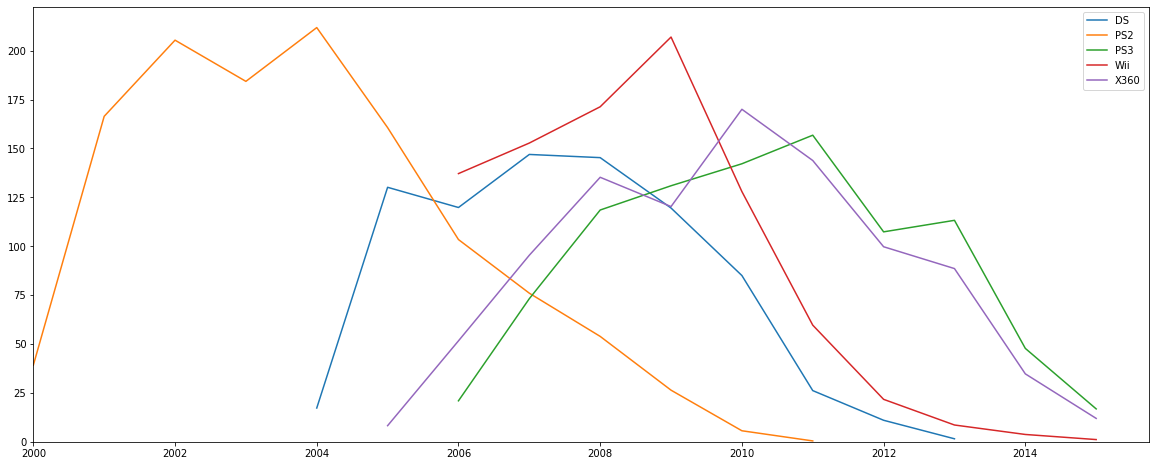

In [40]:
plt.figure(figsize=(20,8))
for platform in platforms_list:
    plt.plot(df.query('2000 <= year_of_release < 2016 & platform == @platform').groupby('year_of_release')['total_sales'].sum(), label=platform)
plt.ylim(0)
plt.xlim(2000)
plt.legend()
plt.show()

С другой стороны мы видим, что время жизни этих платформ подходит или подошло к концу. Посмотрим, что актуально в последние 5 лет.

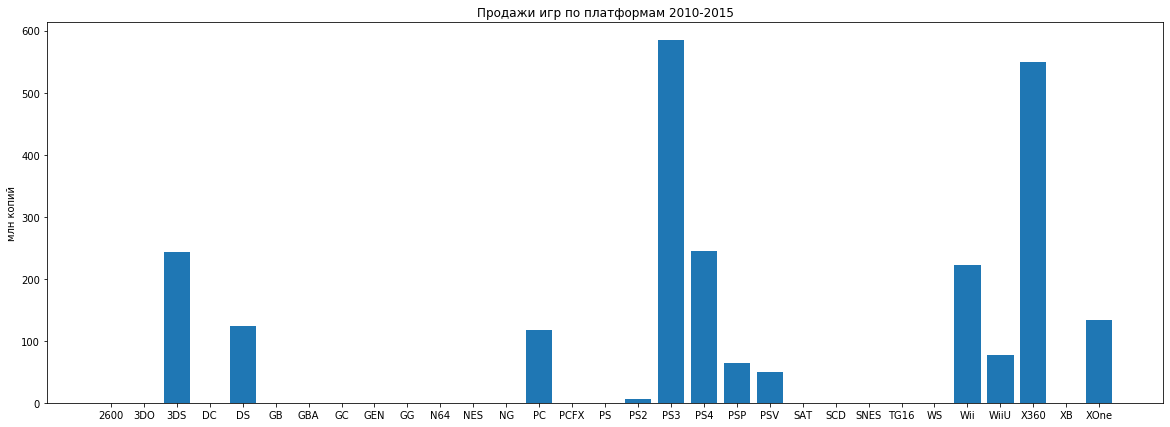

In [41]:
plt.figure(figsize=(20,7))
plt.bar(sorted(df['platform'].unique()), 
        df.query('2015 >= year_of_release >= 2010').groupby('platform')['total_sales'].sum())
plt.title('Продажи игр по платформам 2010-2015')
plt.ylabel('млн копий')
plt.show()

Кроме уже обнаруженных платформ стоит обратить внимание на Nintendo 3DS, PS4, XOne и PC. Эти платформы актуальны на текущий момент и продажи по ним ниже только потому, что вышли они не так давно.

In [42]:
platforms_list2 = ['3DS', 'PS4', 'XOne', 'PC']

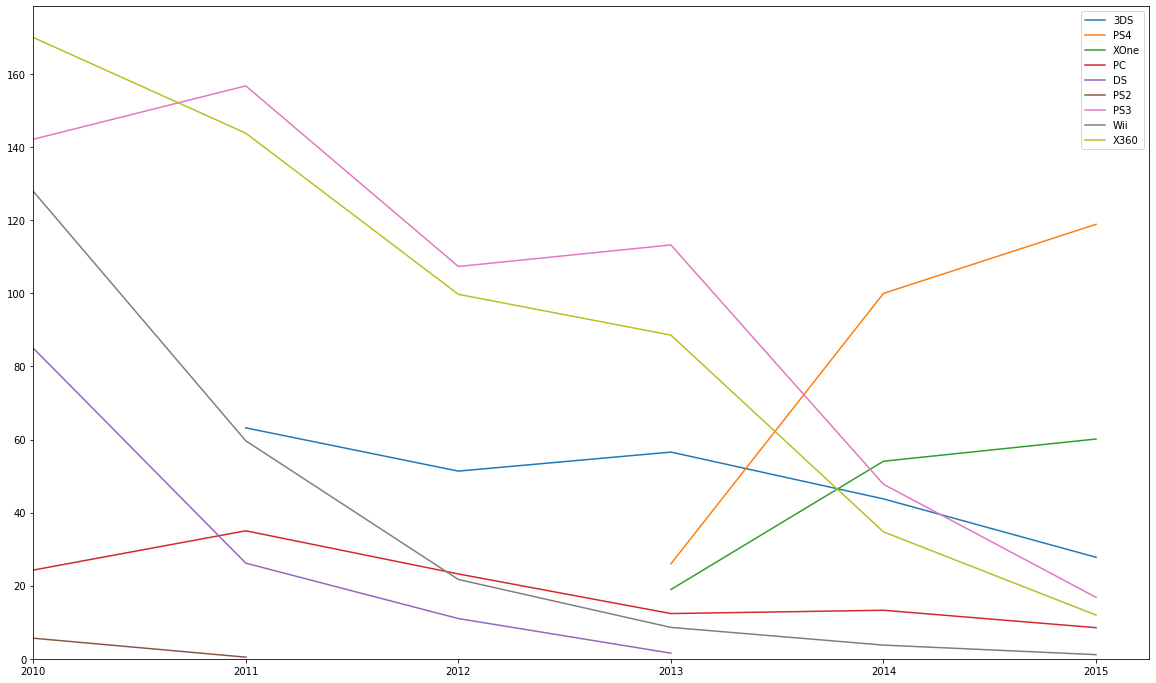

In [43]:
plt.figure(figsize=(20,12))
for platform in platforms_list2+platforms_list:
    plt.plot(df.query('2010 <= year_of_release < 2016 & platform == @platform').groupby('year_of_release')['total_sales'].sum(), label=platform)
plt.ylim(0)
plt.xlim(2010)
plt.legend()
plt.show()

Продажи наших фаворитов падают, растут только новые консоли PS4 и XOne. Возможно мы увидим тренды среди остальных платформ.

In [44]:
platforms_list3 = list(set(df['platform'].unique().tolist()) - set(platforms_list) - set(platforms_list2))

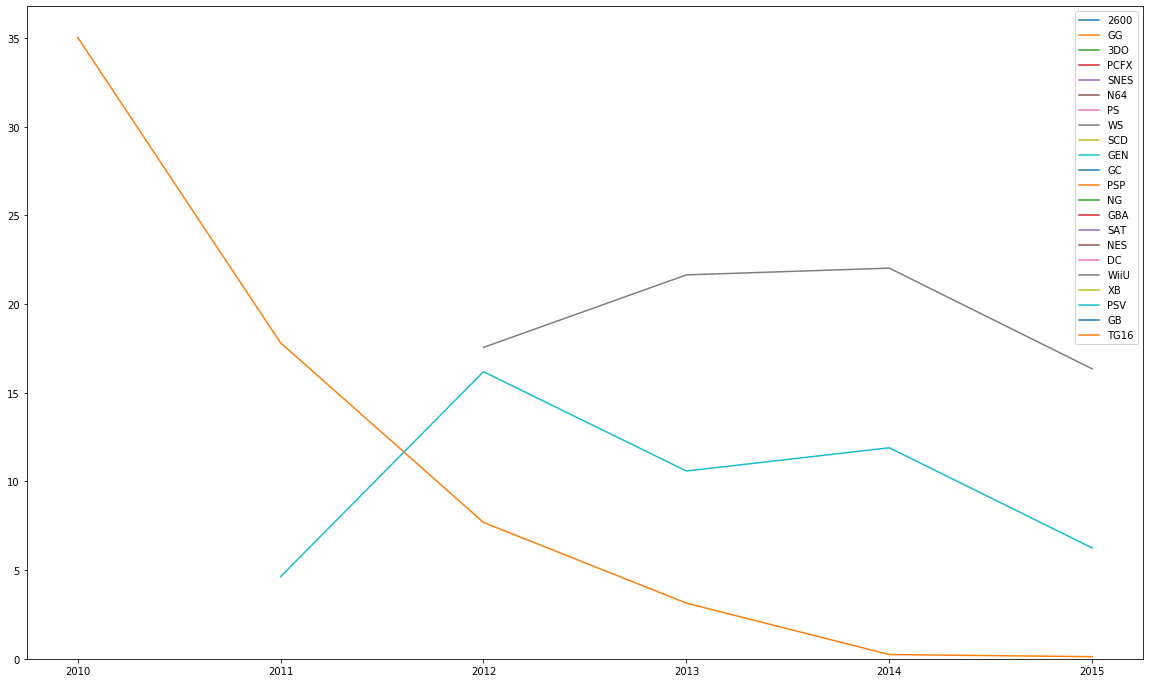

In [45]:
plt.figure(figsize=(20,12))
for platform in platforms_list3:
    plt.plot(df.query('2010 <= year_of_release < 2016 & platform == @platform').groupby('year_of_release')['total_sales'].sum(), label=platform)
plt.ylim(0)
plt.legend()
plt.show()

In [46]:
df.query('2010 <= year_of_release < 2016 & platform in @platforms_list3').pivot_table(index='year_of_release', values='total_sales', columns='platform', aggfunc='sum')

platform,PSP,PSV,WiiU
year_of_release,,,
2010,35.04,NaN,NaN
2011,17.82,4.63,NaN
2012,7.69,16.19,17.56
2013,3.14,10.59,21.65
2014,0.24,11.90,22.03
2015,0.12,6.25,16.35


Продажи игр для PSP почти закончились, PS Vita и WiiU вышли недавно и ещё продаются.

Посмотрим сколько вообще "живут" платформы.

In [47]:
platform_life = df.query('year_of_release > 0').pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max'])
platform_life.columns = ['min_year', 'max_year']
platform_life['lifelong'] = platform_life['max_year'] - platform_life['min_year'] + 1
platform_life.sort_values(by='lifelong', ascending=False)

,min_year,max_year,lifelong
platform,,,
PC,1985,2016,32
DS,1985,2013,29
GB,1988,2001,14
X360,2005,2016,12
PSP,2004,2015,12
PS2,2000,2011,12
NES,1983,1994,12
DC,1998,2008,11
Wii,2006,2016,11


PC по понятным причинам занимает первую позицию, а некоторые платформы прожили всего один или два года (все они 92-96 года выпуска). Посмотрим на медианное значение.

In [48]:
platform_life['lifelong'].median()

7.0

Можно сказать, что платформы живут активной жизнью 7 лет, от старта до прекращения выхода новых игр. Но это не значит, что они перестают зарабатывать деньги для издателей, просто появляется новое железо. Далее я буду использовать этот интервал, как актуальный период для анализа.

In [49]:
df_actual = df.query('year_of_release > 2008').copy()

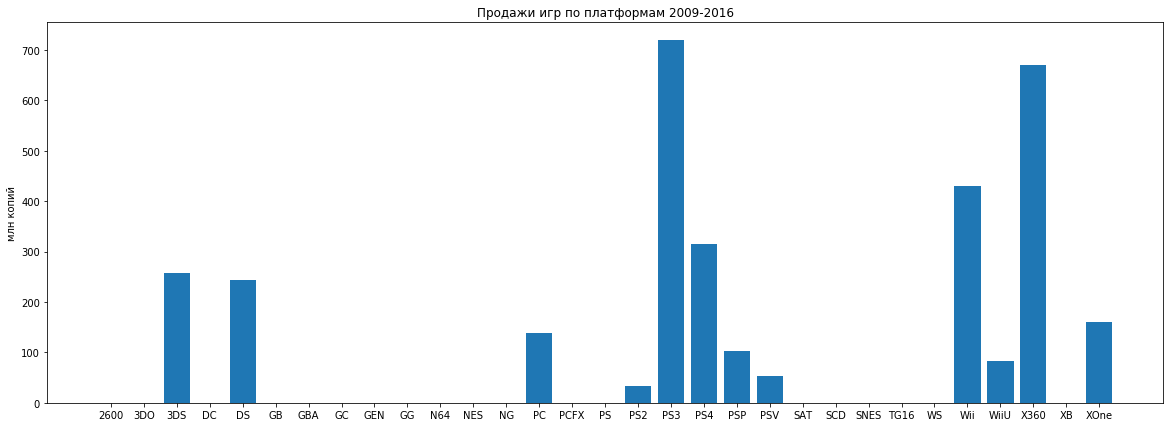

In [50]:
plt.figure(figsize=(20,7))
plt.bar(sorted(df['platform'].unique()), 
        df_actual.groupby('platform')['total_sales'].sum())
plt.title('Продажи игр по платформам 2009-2016')
plt.ylabel('млн копий')
plt.show()

Вернёмся к категоризации платформ. Я выделил топ5 по продажам, ещё 4 актуальные сейчас и остальные.

In [51]:
def platform_category (series):
    if series['platform'] in platforms_list:
        return 'top1'
    elif series['platform'] in platforms_list2:
        return 'top2'
    else:
        return 'top3'
    
df['platform_cat'] = df.apply(platform_category, axis=1)
df['platform_cat'] = df['platform_cat'].astype('category')
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,platform_cat
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54,top1
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,RP,40.24,top3
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52,top1
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77,top1
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,RP,31.38,top3


Теперь у меня есть пометка о том, к какой категории относится платформа. Теперь посмотрим сколько приносят денег игры в рамках платформы.

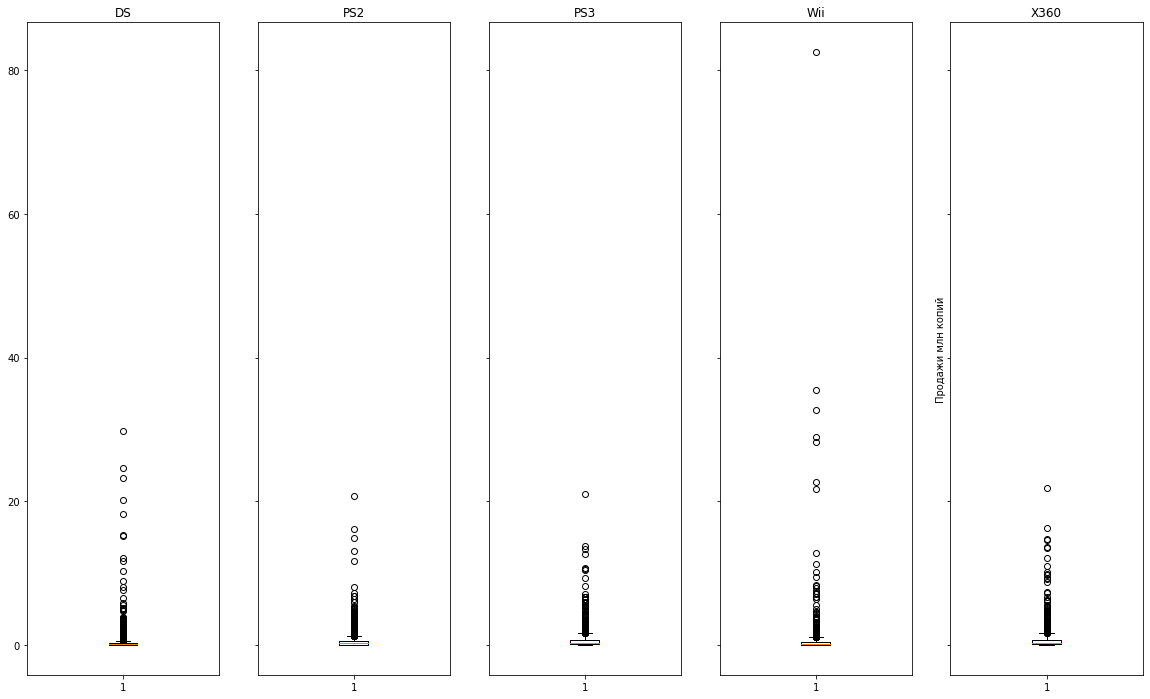

In [52]:
f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(20,12), sharey=True)
for i in range(len(f.axes)):
    f.axes[i].boxplot(df.loc[df['platform'] == platforms_list[i]]['total_sales'])
    f.axes[i].set_title(platforms_list[i])
plt.ylabel('Продажи млн копий')
plt.show()

На графиках видно, что для каждой платформы есть немалое количество очень больших значений, при этом большинство находится очень близко к нулю. Это значит, что большинство игр не приносят большого дохода издателям, а те, что "выстрелили" приносят очень много. Посмотрим внимательнее не зону до 10 млн копий.

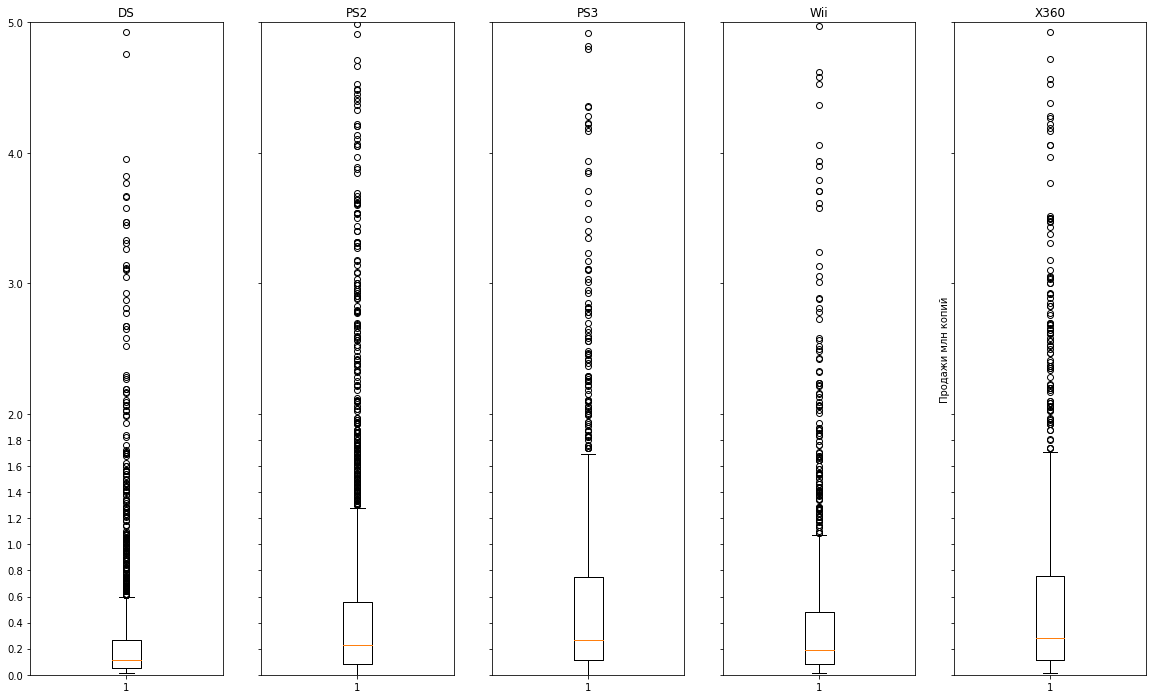

In [53]:
f, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(20,12), sharey=True)
for i in range(len(f.axes)):
    f.axes[i].boxplot(df.loc[df['platform'] == platforms_list[i]]['total_sales'])
    f.axes[i].set_title(platforms_list[i])
plt.ylabel('Продажи млн копий')
plt.ylim(0,5)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2, 3,4,5])
plt.show()

Исходя из графиков мы видим, что большинство игр (на некоторых платформах это значение около 99%) не расходятся тиражом более 1 млн копий. При этом есть Оставшиеся релизы, которые расходятся огромными тиражами, зона от 2 до 4 млн копий заполнена достаточно плотно, а на полном графике есть и релизы с тиражом выше 20 млн копий, видимо они и держат эту индустрию. Правда от части из них нам нужно будет избавиться, когда мы захотим посмотреть на самые успешные жанры игр, т.к. эти выбросы будут нам мешать. Также исходя из графиков можно отметить, что более успешными можно считать игры вышедшие на PS3 и X360, на этих графиках медиана и 3 квартиль значительно выше, чем на других платформах, а верхний ус выступает достаточно высоко. При этом можно отметить, что у PS2 куда более длинный и плотный хвост. Общий вывод который можно сделать исходя из графиков - платформа не так сильно влияет на коммерческий успех релиза, она скорее определяет предельное значение исходя из количества проданных устройств. Вполне вероятно, что взгляд на эти графики может объяснить падение количества выпускаемых игр после 2009.
Также для полноценной оценки доходности платформы конечно же не хватает стоимости игры на данной платформе либо её суммарной выручки от продаж.

Посмотрим на самые продаваемые игры.

In [54]:
top_games = df.pivot_table(index='name', aggfunc={'year_of_release': 'mean','total_sales': 'sum'}).sort_values(by='total_sales', ascending=False).head(30)
top_games['year_of_release'] = top_games['year_of_release'].astype('int')
top_games

,total_sales,year_of_release
name,,
Wii Sports,82.54,2006
Grand Theft Auto V,56.58,2013
Super Mario Bros.,45.31,1992
Tetris,35.84,1988
Mario Kart Wii,35.52,2008
Wii Sports Resort,32.77,2009
Pokemon Red/Pokemon Blue,31.38,1996
Call of Duty: Black Ops,30.82,1608
Call of Duty: Modern Warfare 3,30.60,2011


Этот список лучше тоже сохранить и передать тому, кто будет заниматься рекламными кампаниями. Важно будет обратить внимание на эти игры и их продолжения, они будут вызывать интерес у игроков. В идеале конечно же было бы хорошо оставить в этом списке только названия серии/бренда (к примеру, Call of Duty or Grand Theft Auto).

С учётом того, что мы уже выделили отдельный период для анализа, а также обнаружили невероятно успешные игры, я сделаю отдельный df, где уберу эти значения. Для оценки продаж я буду иногда использовать оба датафрейма или один из них, т.к. я ищу закономерности определяющие успешность игры, а выбросы - это есть такие игры. 

In [55]:
df_clean = df.query('year_of_release > 2008 & total_sales < 15')

### Оценки игр и их влияние

Игроки и критики оценивают игры и дают рекомендации другим, что есть смысл покупать, а что - не стоит. Посмотрим, как эти оценки влияют на продажи.

In [63]:
df_clean.groupby('user_score')['total_sales'].sum().reset_index()['user_score']

0     0.2
1     0.5
2     0.7
3     0.9
4     1.0
     ... 
82    8.9
83    9.0
84    9.1
85    9.2
86    9.3
Name: user_score, Length: 87, dtype: float64

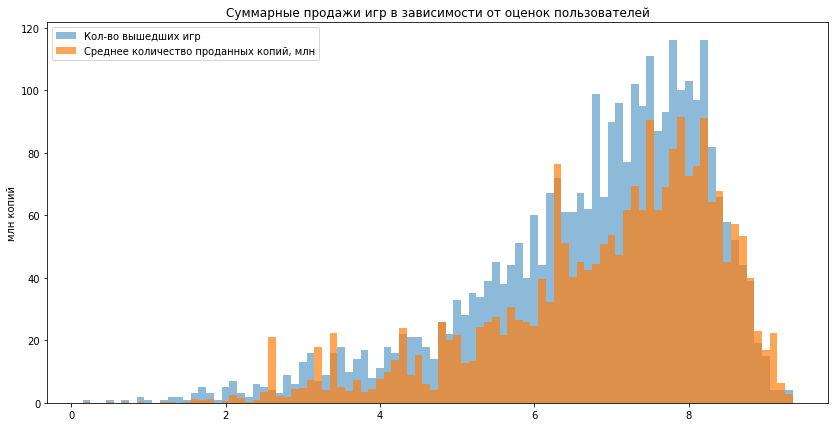

In [74]:
plt.figure(figsize=(14,7))
plt.bar(df_clean.groupby('user_score')['total_sales'].count().reset_index()['user_score'],
        df_clean.groupby('user_score')['total_sales'].count(), 
        label='Кол-во вышедших игр', 
        alpha=0.5,
        width=0.1)
plt.bar(df_clean.groupby('user_score')['total_sales'].sum().reset_index()['user_score'],
        df_clean.groupby('user_score')['total_sales'].sum(), 
        label='Среднее количество проданных копий, млн', 
        alpha=0.7,
        width=0.1)

plt.title('Суммарные продажи игр в зависимости от оценок пользователей')
plt.ylabel('млн копий')
plt.legend()
plt.show()

Если посмотреть на суммарные продажи, то сразу видно, что игры с оценками от 6 до 9 продаются значительно лучше остальных. Спад к 10 можно объяснить меньшим количеством игр с такими высокими оценками. Кроме того мы видим, что и количество выпускаемых игр по оценкам располагаются примерно также. А теперь посмотрим на средние значения.

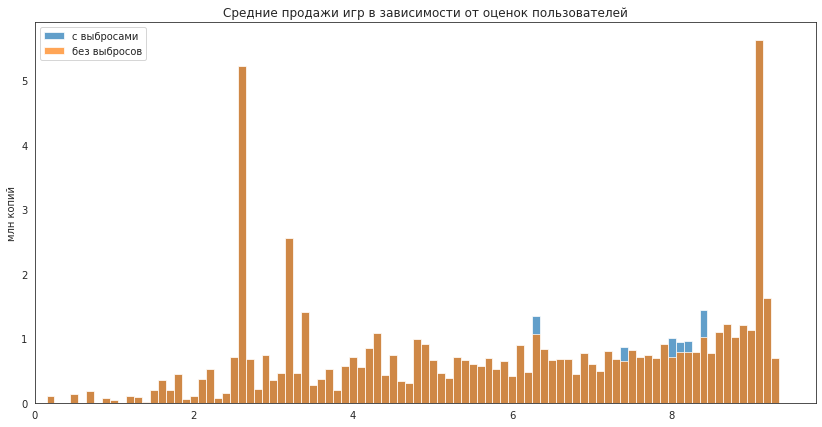

In [122]:
plt.figure(figsize=(14,7))
plt.bar(df_actual.groupby('user_score')['total_sales'].mean().reset_index()['user_score'],
        df_actual.groupby('user_score')['total_sales'].mean(), 
        label='с выбросами', 
        alpha=0.7,
        width=0.1)
plt.bar(df_clean.groupby('user_score')['total_sales'].mean().reset_index()['user_score'],
        df_clean.groupby('user_score')['total_sales'].mean(), 
        label='без выбросов', 
        alpha=0.7,
        width=0.1)

#plt.plot(df_clean.query('year_of_release > 2000 & user_score != 9999').groupby('user_score')['total_sales'].count(), label='кол-во игр')
plt.title('Средние продажи игр в зависимости от оценок пользователей')
plt.ylim(0)
plt.xlim(0)
plt.ylabel('млн копий')
plt.legend()
plt.show()

А вот для среднего значения мы такого сильного роста не видим. Т.е. мы можем сказать, что большинство игр имеют оценки от пользователей выше 6 баллов и это влияет на продажи игры (как видно из графика), но не в значительно степени. Посмотрим, откуда появилось большое значение в районе рейтинга 2,5 и 9, на первом графике роста по количеству релизов я не вижу, поэтому найти будет не сложно.

In [76]:
df_actual.query('2 < user_score < 3').sort_values(by='total_sales', ascending=False).head(10)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
60,Call of Duty: Ghosts,X360,2013,Shooter,6.73,2.56,0.04,0.91,73.0,2.6,M,10.24
69,Call of Duty: Ghosts,PS3,2013,Shooter,4.10,3.63,0.38,1.25,71.0,2.6,M,9.36
675,Kinect: Disneyland Adventures,X360,2011,Misc,1.73,0.43,0.02,0.17,73.0,2.9,E10+,2.35
1040,Call of Duty: Modern Warfare 3,PC,2011,Shooter,0.41,0.98,0.00,0.32,78.0,2.5,M,1.71
1182,FIFA 16,X360,2015,Sports,0.57,0.88,0.00,0.12,NaN,2.9,E,1.57
1314,Madden NFL 15,PS3,2014,Sports,1.08,0.11,0.00,0.27,NaN,2.7,E,1.46
1351,SimCity (2013),PC,2013,Simulation,0.48,0.77,0.00,0.17,64.0,2.2,E10+,1.42
1368,The Sims 3,Wii,2010,Simulation,0.57,0.69,0.00,0.14,NaN,2.5,T,1.40
1828,Guitar Hero 5,PS2,2009,Misc,0.28,0.30,0.00,0.54,71.0,2.6,T,1.12
1884,Sonic Free Riders,X360,2010,Racing,0.74,0.25,0.00,0.09,47.0,2.1,E,1.08


Сразу понятно, что это Call of Duty: Ghosts хорошо оценённый критиками, но не так впечатливший игроков обеих основных консолей. Похоже есть смысл посмотреть, как влияют на продажи оценки критиков.

In [77]:
df_actual.query('10 > user_score > 9').sort_values(by='total_sales', ascending=False)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
97,Super Mario Galaxy 2,Wii,2010,Platform,3.56,2.35,0.98,0.62,97.0,9.1,E,7.51
110,Mario Kart 8,WiiU,2014,Racing,3.15,2.15,1.28,0.51,88.0,9.1,E,7.09
149,The Last of Us,PS3,2013,Action,2.41,2.18,0.28,0.99,95.0,9.1,M,5.86
303,The Witcher 3: Wild Hunt,PS4,2015,Role-Playing,1.02,2.13,0.23,0.59,92.0,9.2,M,3.97
848,Fire Emblem: Awakening,3DS,2012,Role-Playing,0.90,0.45,0.54,0.13,92.0,9.1,T,2.02
1432,Gardening Mama,DS,2009,Puzzle,0.79,0.42,0.01,0.13,60.0,9.3,E,1.35
1499,The Witcher 3: Wild Hunt,XOne,2015,Role-Playing,0.69,0.50,0.00,0.11,91.0,9.2,M,1.30
1831,Persona 4: Golden,PSV,2012,Role-Playing,0.36,0.23,0.38,0.15,93.0,9.2,M,1.12
2851,The Witcher 3: Wild Hunt,PC,2015,Role-Playing,0.21,0.46,0.00,0.05,93.0,9.3,M,0.72
3285,Metroid Prime: Trilogy,Wii,2009,Shooter,0.42,0.05,0.00,0.14,91.0,9.3,T,0.61


Можно точно отметить, что релизы получившие высокие оценки от обеих сторон зачастую имеют очень хорошие показатели по продажам. Невысокие показатели только у игр вышедших на PSV, продажи которых есть смысл оценивать только в сравнении с другими играми на этой платформе. Похоже есть смысл посмотреть, как влияют на продажи оценки критиков.

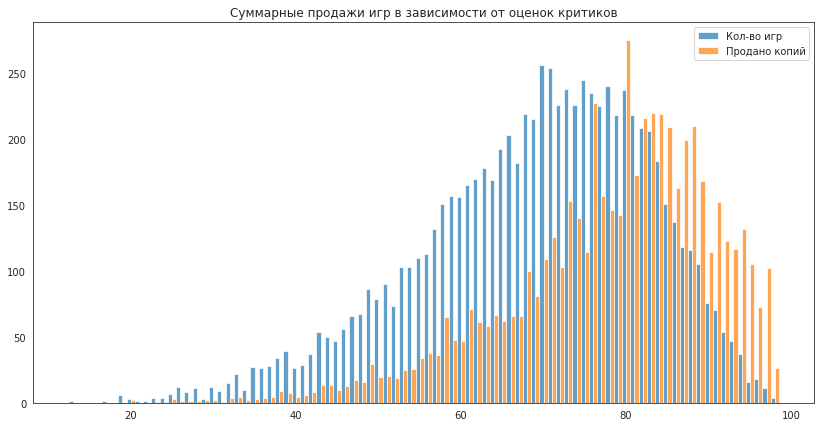

In [133]:
plt.figure(figsize=(14,7))
plt.bar(df.groupby('critic_score')['total_sales'].count().reset_index()['critic_score']-0.25,
        df.groupby('critic_score')['total_sales'].count(), 
        label='Кол-во игр', 
        alpha=0.7,
        width=0.5)
plt.bar(df.groupby('critic_score')['total_sales'].sum().reset_index()['critic_score']+0.25,
        df.groupby('critic_score')['total_sales'].sum(), 
        label='Продано копий', 
        alpha=0.7,
        width=0.5)

plt.title('Суммарные продажи игр в зависимости от оценок критиков')
plt.legend()
plt.show()

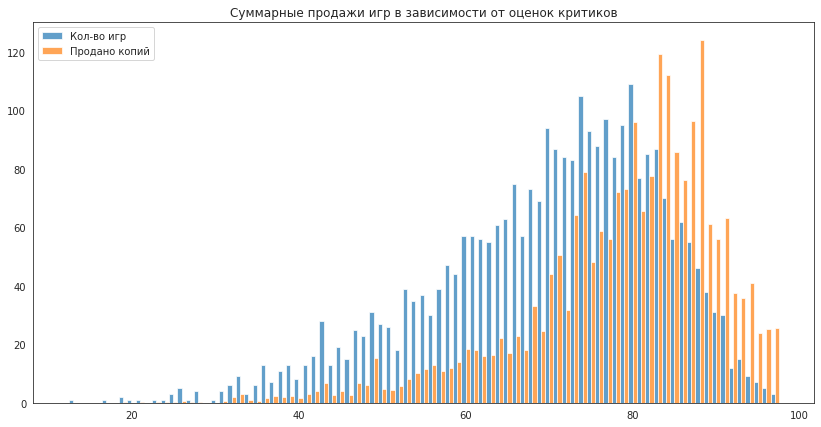

In [137]:
plt.figure(figsize=(14,7))
plt.bar(df_clean.groupby('critic_score')['total_sales'].count().reset_index()['critic_score']-0.25,
        df_clean.groupby('critic_score')['total_sales'].count(), 
        label='Кол-во игр', 
        alpha=0.7,
        width=0.5)
plt.bar(df_clean.groupby('critic_score')['total_sales'].sum().reset_index()['critic_score']+0.25,
        df_clean.groupby('critic_score')['total_sales'].sum(), 
        label='Продано копий', 
        alpha=0.7,
        width=0.5)

plt.title('Суммарные продажи игр в зависимости от оценок критиков')
plt.legend()
plt.show()

По оценкам критиков есть явное смещение относительно первого графика. Оценки ставятся ниже, а вот продажи выше с ещё более высокими оценками. В районе рейтинга 85-90 можно увидеть пик по продажам на фоне снижения количества игр, похоже на что-то очень успешно и высоко оценённое, вроде Ведьмака 3. На актуальном периоде в 7 лет это тенденция становится ещё более заметной. Посмотрим на средние значения.

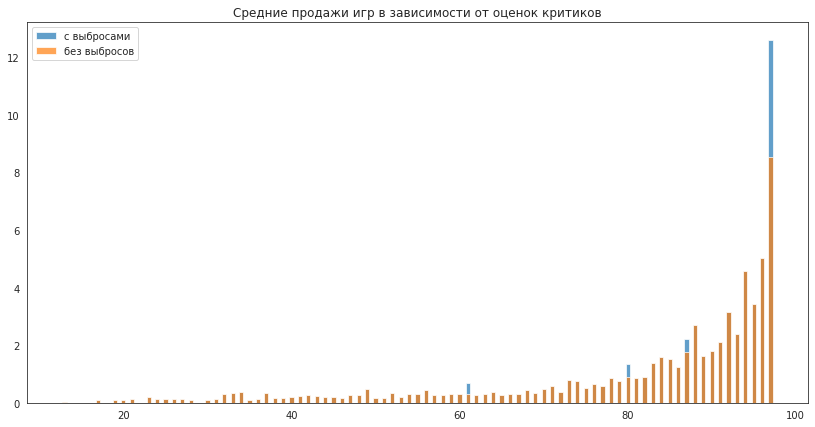

In [140]:
plt.figure(figsize=(14,7))
plt.bar(df_actual.groupby('critic_score')['total_sales'].mean().reset_index()['critic_score'],
        df_actual.groupby('critic_score')['total_sales'].mean(), 
        label='с выбросами', 
        alpha=0.7,
        width=0.5)
plt.bar(df_clean.groupby('critic_score')['total_sales'].mean().reset_index()['critic_score'],
        df_clean.groupby('critic_score')['total_sales'].mean(), 
        label='без выбросов', 
        alpha=0.7,
        width=0.5)


plt.title('Средние продажи игр в зависимости от оценок критиков')
plt.legend()
plt.show()

А вот здесь всё более чем понятно из графика - критики имеют очень сильное влияние на продажи супер успешных игр. Игры с оценками до 70 баллов продаются не очень активно, но зато с 90 начинается резки рост. Похоже всё-таки нужно смотреть на эти оценки.

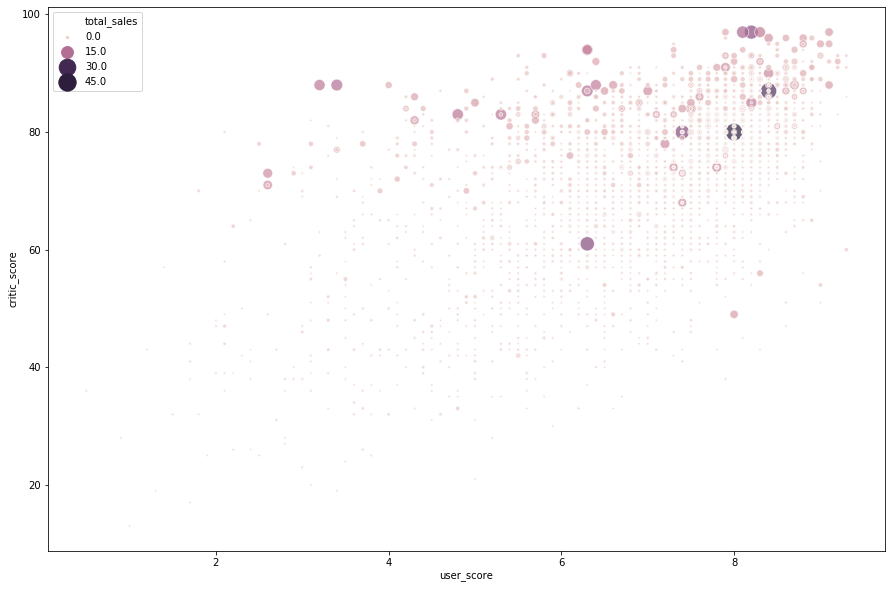

In [81]:
g=sns.scatterplot(data=df_actual.query('user_score != 9999 & critic_score != 9999'), 
                x="user_score", 
                y="critic_score", 
                hue='total_sales', 
                size='total_sales', 
                sizes=(5, 300),
                alpha=0.7)
g.figure.set_figheight(10)
g.figure.set_figwidth(15)
sns.set_style("white")

Получилось вроде красиво, но не очень понятно.

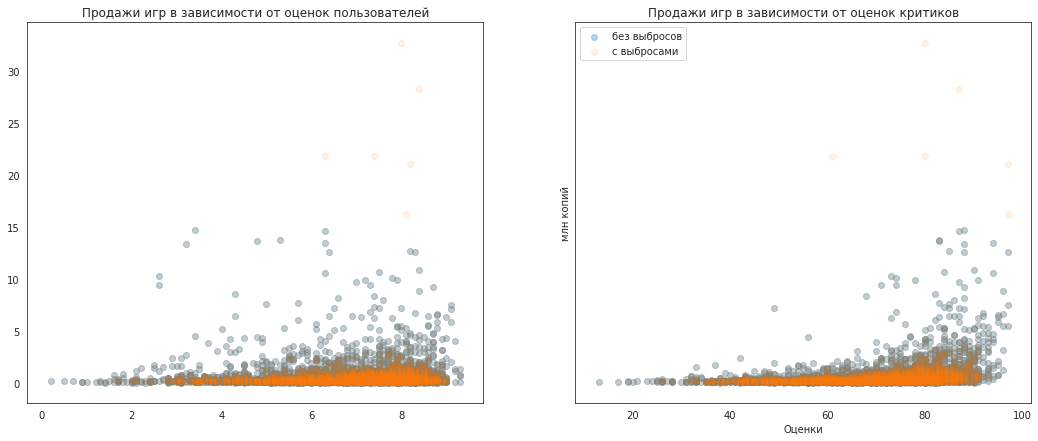

In [82]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7), sharey=True)
ax1.scatter(data=df_clean.query('0 < user_score < 9999 & total_sales < 80'), 
            y='total_sales', 
            x='user_score', 
            alpha=0.3, 
            label='без выбросов')
ax2.scatter(data=df_clean.query('0 < critic_score < 9999 & total_sales < 80'), 
            y='total_sales', 
            x='critic_score', 
            alpha=0.3, 
            label='без выбросов')
ax1.set_title('Продажи игр в зависимости от оценок пользователей')
ax1.scatter(data=df_actual.query('0 < user_score < 9999 & total_sales < 80'), 
            y='total_sales', 
            x='user_score', 
            alpha=0.1, 
            label='с выбросами')
ax2.scatter(data=df_actual.query('0 < critic_score < 9999 & total_sales < 80'), 
            y='total_sales', 
            x='critic_score', 
            alpha=0.1, 
            label='с выбросами')

ax2.set_title('Продажи игр в зависимости от оценок критиков')
plt.xlabel('Оценки')
plt.ylabel('млн копий')
plt.legend()
plt.show()

Из диаграмм рассеяния мы видим картину аналогичную тому, что увидели выше. Продажи игр куда более значительно зависят от оценок критиков, чем от оценок игроков. При этом есть сильное выделяющиеся значения с невысокими оценками. Посмотрим на цифрах.

Рассмотрим на примере одной, но самой успешной платформы - PS2

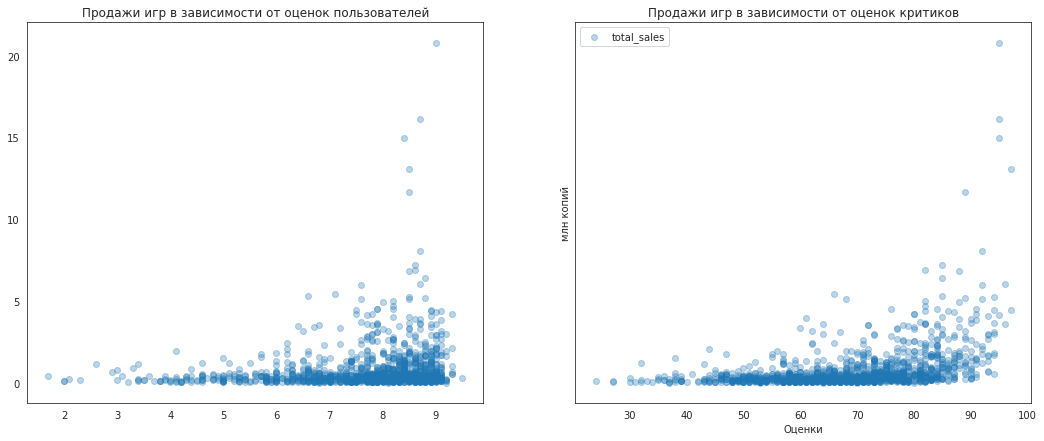

In [83]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7), sharey=True)
ax1.scatter(data=df.query('0 < user_score < 9999 & total_sales < 80 & platform == "PS2"'), 
            y='total_sales', 
            x='user_score', 
            alpha=0.3)



ax1.set_title('Продажи игр в зависимости от оценок пользователей')

ax2.scatter(data=df.query('0 < critic_score < 9999 & total_sales < 80 & platform == "PS2"'), 
            y='total_sales', 
            x='critic_score', 
            alpha=0.3)


ax2.set_title('Продажи игр в зависимости от оценок критиков')

plt.xlabel('Оценки')
plt.ylabel('млн копий')
plt.legend()
plt.show()

На примере одной платформы прослеживается та же ситуация, рекордные продажи у игр с высокими оценками пользователей и особенно критиков. В зоне низких оценок ни на одном из графиков нет рекордсменов.

In [84]:
df.query('platform == "PS2" & user_score < 9999 & critic_score < 9999')[['critic_score', 'user_score', 'total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.563254,0.38922
user_score,0.563254,1.000000,0.16942
total_sales,0.389220,0.169420,1.00000


На цифрах всё немного по-другому:
- видна корреляция между оценками критиков и пользователей, что вполне логично - и те, и другие, оценивают по похожим критериям
- корреляция продаж с оценками небольшая для оценок пользователей, но уже средняя для оценок критиков. Выше на графике видно, что продажи в зависимости от оценкок критиков изменяются неленийно, с быстрым ростов для высоких оценок - нелинейность этого изменения также могла повлиять корреляцию этих показателей.
Как промежуточный вывод можно заявить, что игры с невероятно высокими продажами чаще имеют высокие оценки критиков 

### Жанры

Посмотрим на самые популярные жанры и изменение их популярности со временем.

In [85]:
df_clean.loc[(df_clean['year_of_release'] < 2016) ].pivot_table(index='year_of_release',
                                                                      values='total_sales',
                                                                      columns='genre')

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
year_of_release,,,,,,,,,,,,
2009,0.506213,0.144500,0.601887,0.368010,0.436071,0.250506,0.401071,0.459320,0.769889,0.267642,0.457459,0.192031
2010,0.510133,0.104314,0.367250,0.366600,1.001290,0.250000,0.602982,0.534510,0.948519,0.265309,0.490538,0.258113
2011,0.490252,0.144537,0.448200,0.297158,0.748108,0.115349,0.535538,0.556105,1.044468,0.270357,0.463471,0.191739
2012,0.450000,0.101579,0.316552,0.600541,1.670000,0.156364,0.453667,0.601410,1.494792,0.742222,0.563333,0.217333
2013,0.587517,0.101500,0.354500,0.601667,0.681667,0.320000,0.773125,0.626056,1.051525,0.479444,0.776792,0.322105
2014,0.517181,0.074267,0.689130,0.556667,0.881000,0.212857,0.617037,0.512584,1.387447,0.507273,0.836111,0.122500
2015,0.284664,0.151111,0.376190,0.296667,0.465385,0.118333,0.448333,0.482564,1.985588,0.377333,0.692203,0.115625


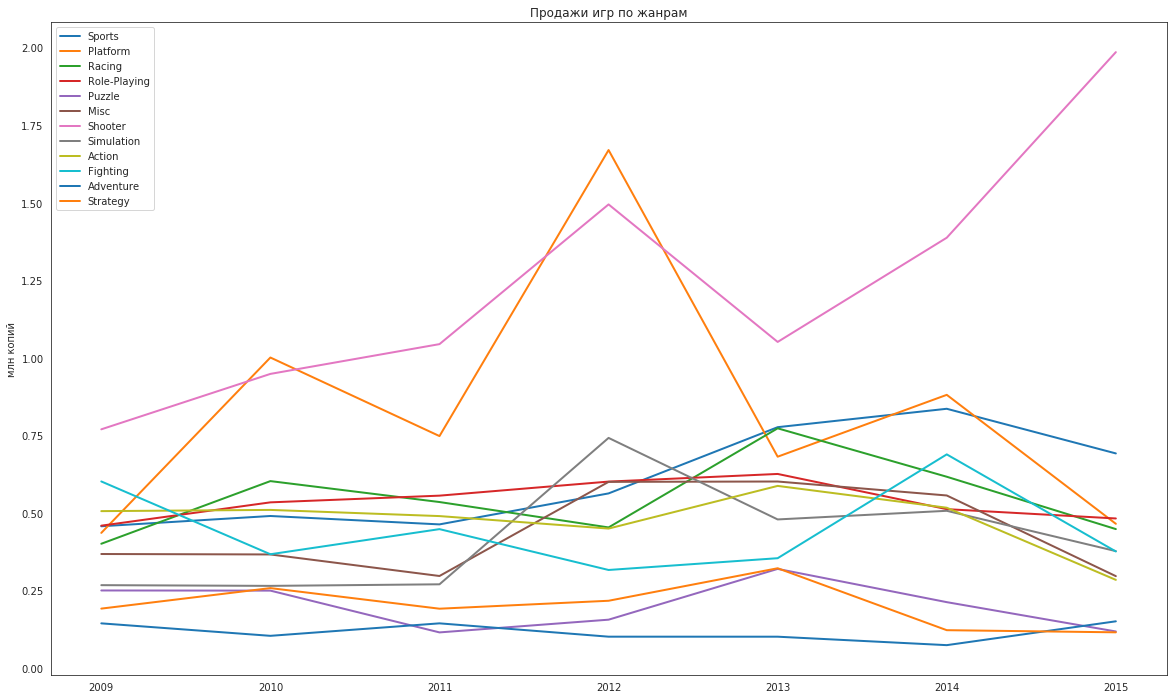

In [86]:
plt.figure(figsize=(20,12))
for genre in df['genre'].unique():
    plt.plot(df_clean.loc[(df_clean['year_of_release'] < 2016) 
                          & (df_clean['genre'] == genre)].pivot_table(index='year_of_release',
                                                                      values='total_sales',
                                                                      columns='genre'),
            label=genre,
            linewidth=2.0)
plt.title('Продажи игр по жанрам')
plt.ylabel('млн копий')
plt.legend()
plt.show()

Исходя из графика можно наблюдать следующие тенденции:
- шутеры стремятся вверх и становятся наиболее продаваемыми играми
- платформеры циклично то растут, то падают в продажах (лучше бы узнать данные за 16 год, чтобы сказать, что ожидать дальше)
- жанр спортивных игр на подъёме последние 4 года, но есть тренд к снижению продаж в 2015
- РПГ колеблется примерно на одном уровне
- гоночные симуляторы ведут себя похожим с РПГ образом
- файтинги потеряли свою популярность с 2000 года, но все ещё на плаву со значительными колебаниями

In [87]:
df_clean.query('year_of_release < 2016').pivot_table(index='year_of_release',values='total_sales',columns='genre',margins=True,aggfunc='sum')

genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,All
year_of_release,,,,,,,,,,,,,
2009,137.69,20.23,31.90,75.81,12.21,19.79,33.69,47.31,69.29,32.92,82.80,12.29,575.93
2010,115.29,15.96,14.69,73.32,31.04,10.75,34.37,54.52,76.83,21.49,91.24,13.68,553.18
2011,116.68,15.61,22.41,54.38,27.68,4.96,34.81,52.83,98.18,15.14,56.08,8.82,507.58
2012,119.25,5.79,9.18,22.22,18.37,1.72,13.61,46.91,71.75,13.36,30.42,3.26,355.84
2013,85.19,6.09,7.09,25.27,24.54,0.96,12.37,44.45,62.04,8.63,41.17,6.12,323.92
2014,97.23,5.57,15.85,23.38,8.81,1.49,16.66,45.62,65.21,5.58,45.15,0.98,331.53
2015,72.02,8.16,7.90,11.57,6.05,0.71,8.07,37.64,67.51,5.66,40.84,1.85,267.98
All,743.35,77.41,109.02,285.95,128.70,40.38,153.58,329.28,510.81,102.78,387.70,47.00,2915.96


По итогу за 2009-2015 годы больше всего заработали шутеры, РПГ, спортивные симмуляторы и жанр Action, продажи по последним двум упали почти в два раза. Остальные жанры сильно отстают.
Хуже всего продаются жанры: Puzzle, Strategy, Simulation (похоже у Sims проблемы) и прочие, не попавшие в конкретные категории. Кроме того можно отметить в последнее время общее снижение кол-ва продаж.

### Вывод

1. Наиболее продаваемые жанры - Shooter, Shooter, Sports, Adventure, Action. Наиболее не продаваемые - Puzzle, Strategy, Simulation
2. Игры с самыми большими показателями продаж почти всегда имеют высокие оценки критиков, на них можно опираться при выборе рекламной стратегии. Оценки пользователей менее важны, но зачастую тоже показательны. К моменту появления таковых в большое количестве вероятно уже может появиться и информация о количестве продаж.
3. Я выделил категорию крупнейших по количеству проданных игр платформ, а так же ещё одну - продажи по которой будут расти в ближайшем будущем, т.к. большинство платформ из первого списка переходят на новое поколение. Мой вывод - выбор платформы определяет максимальную аудиторию для игры (чем влияет на продажи), но не имеет значительного влияния на продажи конкретной игры (если не говорить об эксклюзивах).
Итого: можно делать упор на игры Shooter, Shooter, Sports, Adventure с высокими оценками критиков на платформах: '3DS', 'PS4', 'XOne', 'PC', а также на известные крупные серии (типа GTA V)



## Портрет пользователя

Сейчас я посмотрю на показатели по продажам в каждом отдельном регионе.

In [88]:
df[['na_sales', 'eu_sales', 'jp_sales']].sum()

na_sales    4400.57
eu_sales    2424.14
jp_sales    1297.34
dtype: float64

Можно смело заявить, что Северная Америка имеет крупнейший рынок по продажи игр.

In [89]:
df_na = df_actual.loc[df['na_sales'] > 0].copy()
df_na.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4363 entries, 3 to 16696
Data columns (total 12 columns):
name               4363 non-null object
platform           4363 non-null category
year_of_release    4363 non-null uint64
genre              4363 non-null category
na_sales           4363 non-null float64
eu_sales           4363 non-null float64
jp_sales           4363 non-null float64
other_sales        4363 non-null float64
critic_score       2590 non-null float64
user_score         2694 non-null float64
rating             4363 non-null category
total_sales        4363 non-null float64
dtypes: category(3), float64(7), object(1), uint64(1)
memory usage: 355.7+ KB


### Платформы

In [90]:
na_top10_platforms = df_na.groupby('platform')['na_sales'].sum().sort_values(ascending=False).head(10)

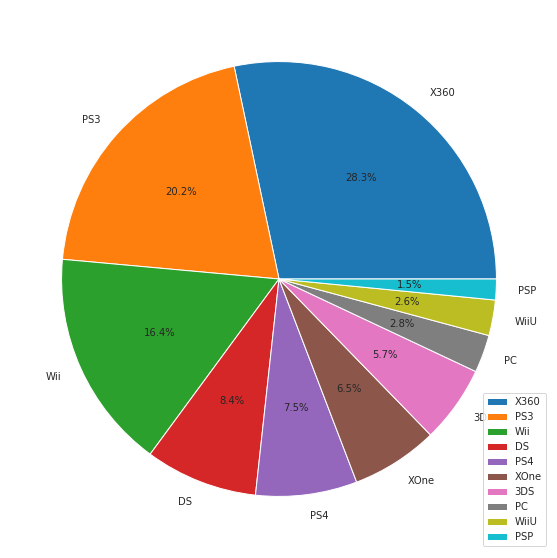

In [91]:
plt.figure(figsize=(10,10))
plt.pie(na_top10_platforms, labels=na_top10_platforms.index,  autopct='%1.1f%%')
plt.legend()
plt.show()

Топ 10 платформ в Северной Америке выглядит так. Попробуем объединить вместе продажи по брендам платформ.

In [92]:
na_top10_platforms

platform
X360    408.18
PS3     291.90
Wii     235.75
DS      120.61
PS4     108.74
XOne     93.12
3DS      82.65
PC       40.49
WiiU     38.10
PSP      22.27
Name: na_sales, dtype: float64

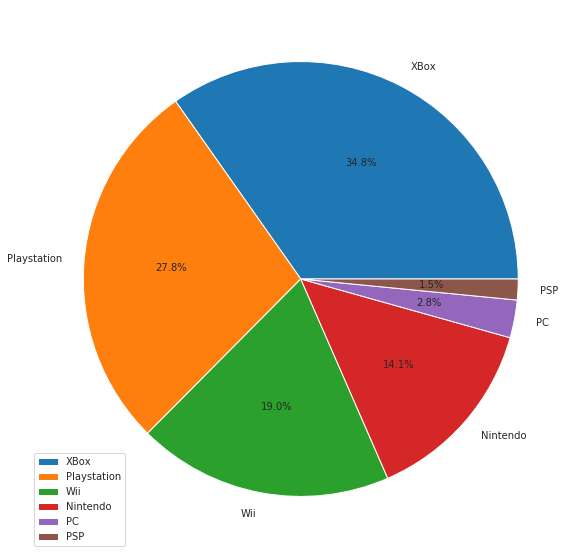

In [93]:
labels = 'XBox', 'Playstation', 'Wii', 'Nintendo', 'PC', 'PSP'
sizes = [408.18+93.12, 291.90+108.74, 235.75+38.10, 120.61+82.65, 40.49, 22.27]

plt.figure(figsize=(10,10))
plt.pie(sizes, labels=labels,  autopct='%1.1f%%')
plt.legend()
plt.show()

В актуальный исследуемый период наиболее популярны в Северной Америке консоли Xbox и PlayStation (с перевесом в пользу первого), а также Wii и Nintendo. Посмотрим топ10 по другим регионам и сравним между собой.

In [94]:
df_eu = df_actual.loc[df['eu_sales'] > 0].copy()
df_jp = df_actual.loc[df['jp_sales'] > 0].copy()

In [95]:
eu_top10_platforms = df_eu.groupby('platform')['eu_sales'].sum().sort_values(ascending=False).head(10)
jp_top10_platforms = df_jp.groupby('platform')['jp_sales'].sum().sort_values(ascending=False).head(10)

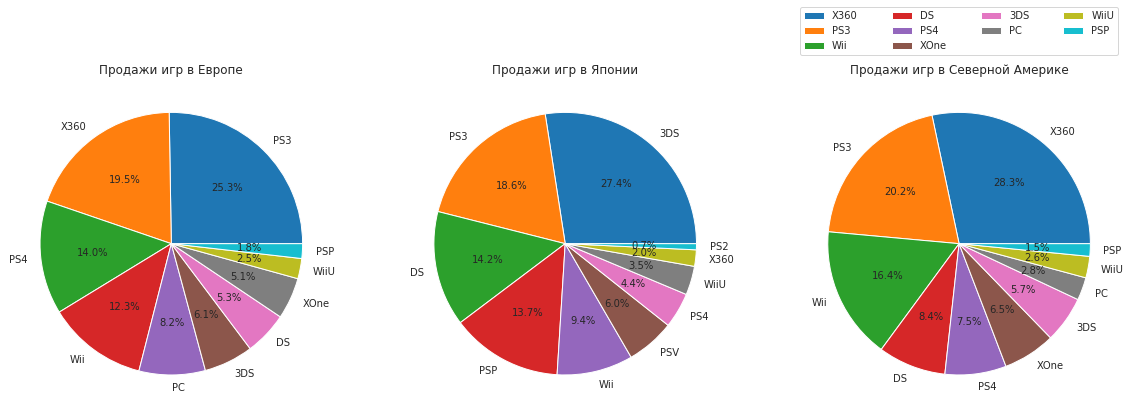

In [96]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))

ax1.pie(eu_top10_platforms, labels=eu_top10_platforms.index,  autopct='%1.1f%%')
ax2.pie(jp_top10_platforms, labels=jp_top10_platforms.index,  autopct='%1.1f%%')
ax3.pie(na_top10_platforms, labels=na_top10_platforms.index,  autopct='%1.1f%%')
ax1.set_title('Продажи игр в Европе')
ax2.set_title('Продажи игр в Японии')
ax3.set_title('Продажи игр в Северной Америке')
plt.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left',
           ncol=4, mode="expand", borderaxespad=0.5)
plt.show()

Выбор платформ ощутимо отличается в разных регионах, хотя в ТОП 10 везде одни и те же имена.
В Японии предпочитают продукты Nintendo - это 40% всего рынка, так же стоит обратить внимание на большую долю PSP относительно других регионов и полное отсутствие PC.
В Северной Америке предпочитают XBox и PS, более чем в других регионах популярны Wii.
В Европе предпочтения схожи, но куда большую долю занимает PS - суммарно около 40% рынка, также здесь самая большая доля игр проданных для PC.

### Жанры

Теперь посмотрим на популярные жанры

In [97]:
na_top5_genres = df_na.groupby('genre')['na_sales'].sum().sort_values(ascending=False).head(5)
eu_top5_genres = df_eu.groupby('genre')['eu_sales'].sum().sort_values(ascending=False).head(5)
jp_top5_genres = df_jp.groupby('genre')['jp_sales'].sum().sort_values(ascending=False).head(5)

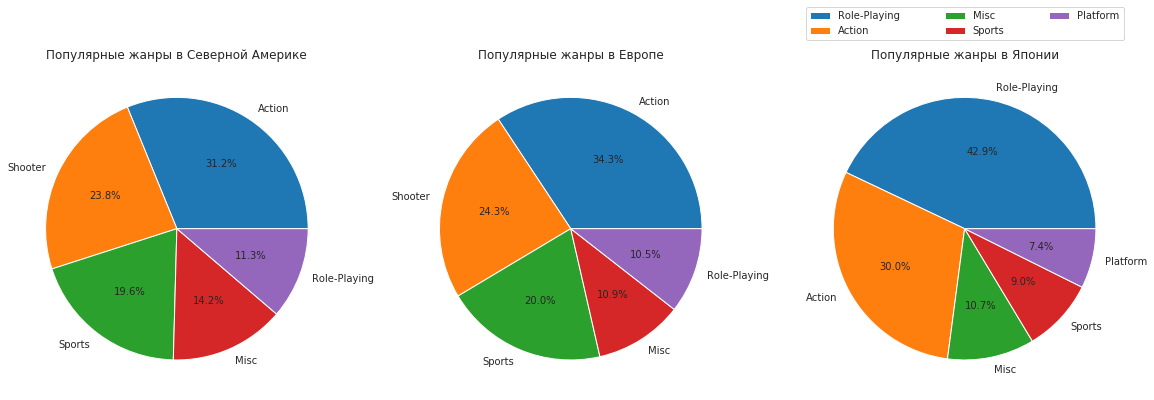

In [98]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))

ax2.pie(eu_top5_genres, labels=eu_top5_genres.index,  autopct='%1.1f%%')
ax3.pie(jp_top5_genres, labels=jp_top5_genres.index,  autopct='%1.1f%%')
ax1.pie(na_top5_genres, labels=na_top5_genres.index,  autopct='%1.1f%%')
ax2.set_title('Популярные жанры в Европе')
ax3.set_title('Популярные жанры в Японии')
ax1.set_title('Популярные жанры в Северной Америке')
plt.legend(bbox_to_anchor=(0., 1.06, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.5)
plt.show()

Популярный везде жанры - Action, а далее уже всё по разному.
Европа и СА предпочитают шутеры и спортивные игры, на последнем месте в нашем топе РПГ.
В Японии всё наоборот, в шутеры активно не играют, РПГ - самый популярный жанр, а платформеры попадают в топ5 продаж.

### ESRB

Посмотрим, как влияет рейтинг ESRB на продажи в различных регионах.

In [99]:
df_actual.query('rating != "RP"').pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'])

,eu_sales,jp_sales,na_sales
rating,,,
E,0.190459,0.044785,0.293634
E10+,0.152610,0.026123,0.254630
EC,0.000000,0.000000,0.220000
M,0.388228,0.042366,0.524209
T,0.138590,0.045741,0.205344


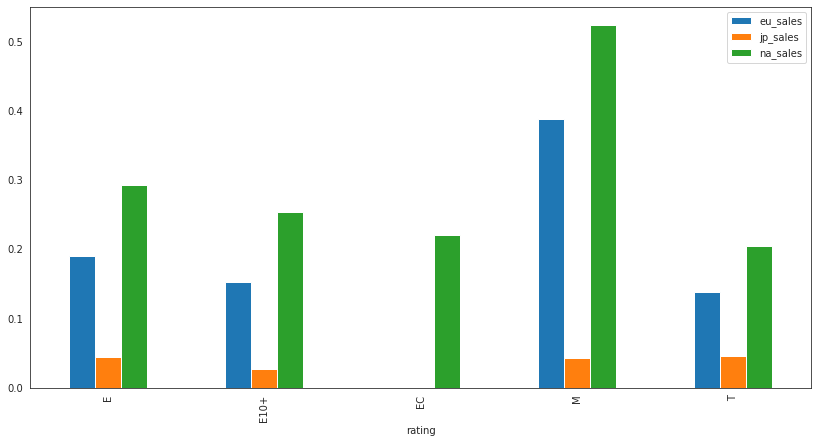

In [100]:
df_actual.query('rating != "RP"').pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales']).plot(kind='bar', figsize=(14,7))

В Европе и США наибольшее количество продаж игр с рейтингом M. Хоть это и самый строгий рейтинг (сильнее всего ограничивает аудиторию), видимо это как раз те люди, которые непосредственно покупают игры. В Японии же игры с таким рейтингом по продажам только на третьем месте. Это может быть связано с более жесткой цензурой в Японии и ввиду этого, отсутствием игр с таким рейтингом (они там или не выходят, или выходят с изменениями, позволяющими получить более широкий допуск к геймерам). 
Отдельно стоит обратить внимание на рейтинг T - разница с M всего один год, т.е. это практически та же аудитория и в СА и Европе эти игры суммарно закрывают почти половину игр, в Японии же таких игр продаётся больше всего, что только укрепляет мою теорию о том, что в игры вносят правки, чтобы получить рейтинг "ниже".
Игры для всех или от 10 лет (E, E10+) продаются традиционно чуть слабее во всех регионах, хотя в Японии их доля достаточно велика. Понятно, что отсутствие ограничений только расширяет потенциальную аудиторию, но вероятно в самих играх становится меньше моментов, интересующих геймеров.
Рейтинг EC (для маленьких детей от 3 лет) похоже вообще есть только в Северной Америке (остальные обходятся E), либо в других регионах игры с таким рейтингом не продают.

## Проверка гипотез

Проверим пару сформилированных в рамках задания гипотез:
 - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
 - Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

### Рейтинги платформ одинаковые

С одной стороны можно предположить, что оценки игр в среднем не сильно отличаются между платформами. Мы видели, что большинство оценок сконцентрировано в одной области. С другой стороны, платформы отличаются по своим возможностям, а где-то могут быть частые случае плохой оптимизации, при переезде с другой платформы. Проверим гипотезу на Xbox One и PC

Для начала посмотрим, как распределены данные.

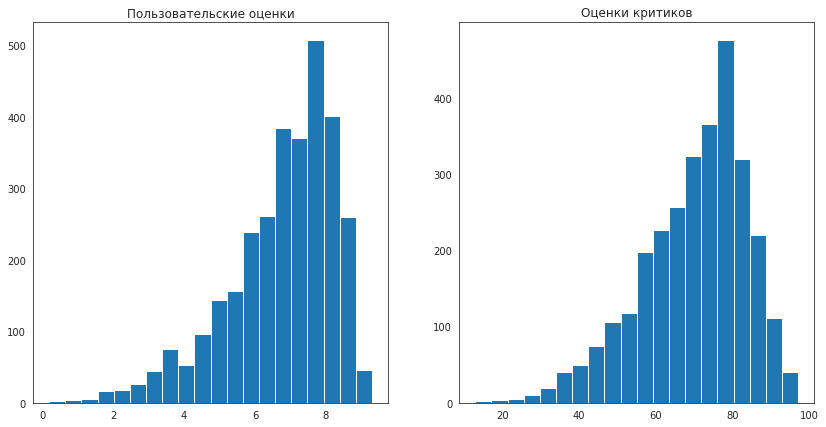

In [101]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
ax1.hist(df_actual.query('user_score < 9999')['user_score'], bins=20)
ax2.hist(df_actual.query('critic_score < 9999')['critic_score'], bins=20)
ax1.set_title('Пользовательские оценки')
ax2.set_title('Оценки критиков')
plt.show()

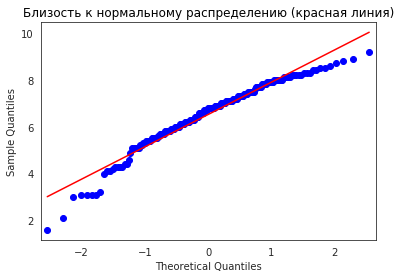

In [102]:
qqplot(df_actual.query('user_score < 9999 & platform == "XOne"')['user_score'], line='s')
plt.title('Близость к нормальному распределению (красная линия)', fontsize=12, color
='black')
plt.show()

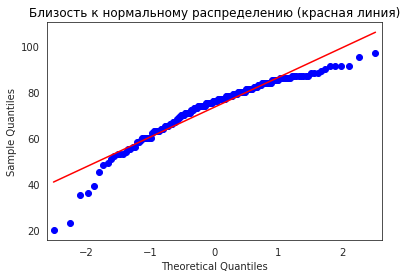

In [103]:
qqplot(df_actual.query('critic_score < 9999 & platform == "XOne"')['critic_score'], line='s')
plt.title('Близость к нормальному распределению (красная линия)', fontsize=12, color
='black')
plt.show()

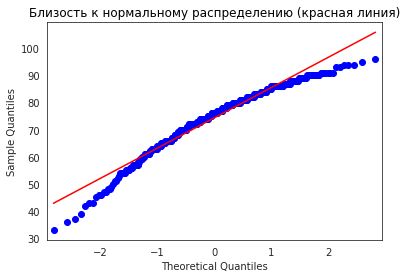

In [104]:
qqplot(df_actual.query('critic_score < 9999 & platform == "PC"')['critic_score'], line='s')
plt.title('Близость к нормальному распределению (красная линия)', fontsize=12, color
='black')
plt.show()

Распределение похоже на нормальное, но есть немножечко сомнений. Проверим с помощью t-test и Манна-Уитни (выбор определённой <a href='https://lit-review.ru/biostatistika/vybor-statisticheskogo-kriteriya/'>этой статьёй</a>). Предварительно сравним дисперсии выборок.

In [105]:
xone = df_actual.query('critic_score < 9999 & user_score < 9999 & platform == "XOne"')
pc = df_actual.query('critic_score < 9999 & user_score < 9999 & platform == "PC"')

In [106]:
def var_equal(df1, df2):
    x = round(df1.var()/df2.var()*100)
    if x >= 5:
        return False
    else:
        return True

var_equal(xone['user_score'], pc['user_score'])

False

In [107]:
var_equal(xone['critic_score'], pc['critic_score'])

False

Перед тестом сформулируем гипотезы:
 - H0 - средние оценки игр Xbox One и PC равны
 - H1 - средние оценки игр Xbox One и PC не равны

In [108]:
alpha = 0.05 #этого будет достаточно

results = st.ttest_ind(xone['user_score'], pc['user_score'])
#equal_var = False , т.к. дисперсия в выборках по тарифам сильно отличается
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.43172603504343243
Не получилось отвергнуть нулевую гипотезу


In [109]:
results = st.mannwhitneyu(xone['user_score'], pc['user_score'])
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.05952846257420905
Не получилось отвергнуть нулевую гипотезу


Опровергнуть то, что средние пользовательские оценки игр на разных платформах не отличаются нам не удалось, т.е. я продолжаю считать, что средние оценки пользователи ставят одинаково на этих двух платформах. 
При этом два теста дали значительно отличающееся значение p. Предварительно я посмотрел, количество повторяющихся значений в обеих выборках (<a href='https://ru.wikipedia.org/wiki/U-критерий_Манна_—_Уитни'>один из критериев применения теста Манна-Уитни - малое кол-во повторяющихся значений</a>). В любом случае мы получили одинаковый итоговый вариант.
Посмотрим на оценки критиков.

In [110]:
results = st.ttest_ind(xone['critic_score'], pc['critic_score'])
#equal_var = False , т.к. дисперсия в выборках по тарифам сильно отличается
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.4156375136213665
Не получилось отвергнуть нулевую гипотезу


Аналогичный результат с оценками криитков, с вероятностью около 40% существующая разница могла получится случайно и средние оценки критиков не отличаются между платформами.

Сравним также как отличаются между собой оценки критиков и пользователей на одной платформе:
 - H0 - средние оценки не отличаются
 - H1 - средние оценки отличаются (мы уже предположили это исходя из графиков ранее)

In [111]:
results = st.ttest_ind(xone['critic_score'], xone['user_score']*10) #в обоих случаях оценки имеют градацию от 0 до 10 или 100, приведу значения к общей
#equal_var = False , т.к. дисперсия в выборках по тарифам сильно отличается
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 2.8059909979779162e-08
Отвергаем нулевую гипотезу


Шанс того, что оценки не отличаются, а разницу которую мы увидели случайна крайне мал. Можем продолжать считать, что пользователи и критики оценивают игры по разному.

### Средние пользовательские рейтинги жанров

Предположим, что какие-то жанры оценивают лучше, а какие-то хуже (легко сделать новую Fifa, но сложно сделать интересный платформер). Гипотеза которую мы проверим:
- H0 - средние пользовательские оценки жанров Sports и Action равны
- H1 - средние пользовательские оценки жанров Sports и Action не равны

In [112]:
action = df_actual.query('user_score < 9999 & genre=="Action"')['user_score']
sports = df_actual.query('user_score < 9999 & genre=="Sports"')['user_score']

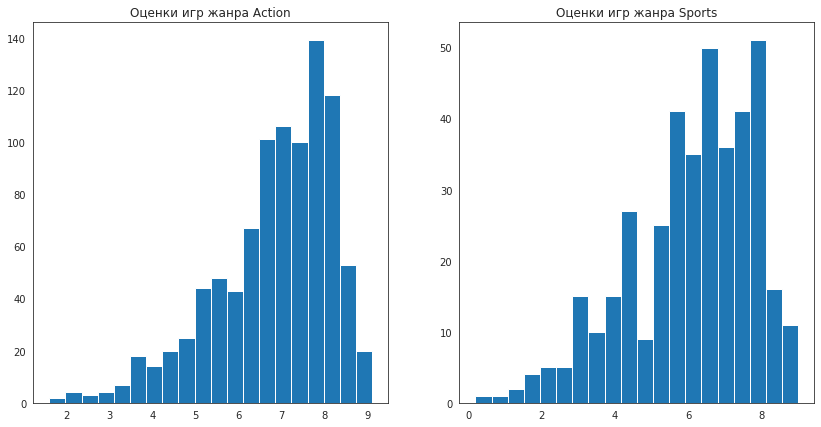

In [113]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))
ax1.hist(action, bins=20)
ax2.hist(sports, bins=20)
ax1.set_title('Оценки игр жанра Action')
ax2.set_title('Оценки игр жанра Sports')
plt.show()

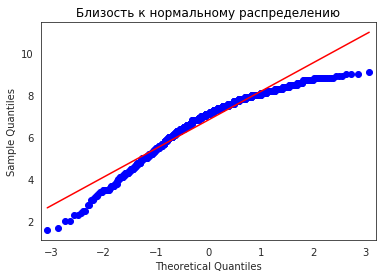

In [114]:
qqplot(action, line='s')
plt.title('Близость к нормальному распределению', fontsize=12, color
='black')
plt.show()

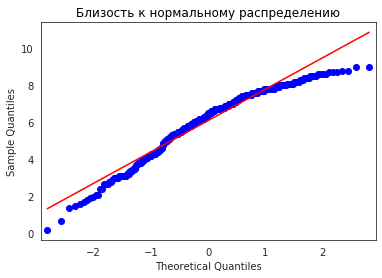

In [115]:
qqplot(sports, line='s')
plt.title('Близость к нормальному распределению', fontsize=12, color
='black')
plt.show()

Распределение близко к нормально, применим тест Стьюдента. Предварительно сравним дисперсии.

In [116]:
var_equal(action,sports)

False

Дисперсии не равны.

In [117]:
results = st.ttest_ind(action, sports)
#equal_var = False , т.к. дисперсия в выборках по тарифам сильно отличается
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 
    
results.statistic

p-значение: 1.0516734948473881e-15
Отвергаем нулевую гипотезу


8.119901667867119

Результаты теста, отвергаем нулевую гипотезу и говорим, что средние оценки сравнимаемых жанров отличаются, вероятность получить такую разницу между ними крайне мала.

## Вывод

На основании исследования мы получили следующие факторы, которые нужно учитывать при планировании активностей на 2017 год:
 - последние годы продажи игр падают (за 7 лет общие продажи снизились в два раза), есть смысл попытаться разобраться в причинах, но точно не нужно закупать больше, чем в прошлом году
 - игры для DS, PS3, PS3, Wii и Xbox360 нужно дораспродавать. Эти платформы имели наибольший коммерческий успех ранее, но сейчас им на смену выходят новые платформы, на которые нужно будет сделать упор в 2017 году. Это Nintendo 3DS, PS4, XOne и PC. При этом спрос на игры для старых платформ ещё может оставаться, в 2016 году на них были новые релизы, которые кто-нибудь да захочет у нас приобрести.

In [118]:
df.query('year_of_release == 2016 & platform == "X360"').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales,platform_cat
5010,FIFA 17,X360,2016,Sports,0.07,0.28,0.0,0.03,NaN,1.7,E,0.38,top1
5689,LEGO Marvel's Avengers,X360,2016,Action,0.18,0.11,0.0,0.03,NaN,5.7,E10+,0.32,top1
8265,Madden NFL 17,X360,2016,Sports,0.14,0.02,0.0,0.02,NaN,0.7,E,0.18,top1
9806,Lego Star Wars: The Force Awakens,X360,2016,Action,0.05,0.06,0.0,0.01,NaN,6.9,E10+,0.12,top1
9861,NBA 2K17,X360,2016,Sports,0.09,0.02,0.0,0.01,NaN,3.4,E,0.12,top1


 - стоит обратить внимание на игры из списка top_games - они ранее показывали наивысшие результаты и вполне вероятно могут продаваться хорошо сами и дальше либо будут продаваться их продолжения
 - рекордные продажи зачастую у игр с высокими оценками критиков. Оценки пользователей также важны, но они появляются позже и оказывают меньшее влияние на продажи игр
 - наиболее популярные среди геймеров жанры Shooter, Shooter, Sports, Adventure и Action. Их популярность ощутимо отличается в зависимости от региона. В Японии, например, топ продаж занимает жанр РПГ, а в Европе и Северной Америке Action, Shooter и Sports делают большую часть продаж. 
 - также стоит обратить внимание по рейтинг ESRB - в Японии лучше продаются игры с рейтингом до M, а в Северной Америке и Европе наоборот, T и M занимают почти половину всех продаж.
 
Также в процессе исследования не была отвергнута гипотеза о том, что средние оценки на разных платформах отличаются (сравнивались Xbox One и PC), т.е. в случае выхода релиза на одной из платформ - мы можем ориентироваться на оценки критиков и пользователей для принятия решений. А гипотезу о том, что средние оценки игр в разных жанрах равны мы отбросили - средние оценки отличаются и нельзя сделать однозначный вывод о качестве игры, сравнивая её по оценкам с игрой другого жанра.